## Imports and Helper Functions

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import warnings

warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [29]:
def plot_garage_data_over_time(df, feature_to_plot, individual_plots=False):
    # get list of unique garages
    unique_garagecodes = df['garagecode'].unique().tolist()

    if individual_plots:
        # 8 individual plots
        for garage in unique_garagecodes:
            filtered_df = df[df['garagecode'] == garage]

            sns.lineplot(x='update_datetime', y=feature_to_plot, data=filtered_df)
            plt.title(garage)
            plt.show()

    else:
        # 1 plot with 4x2 subplots
        row_count = 4
        col_count = 2

        fig, axes = plt.subplots(nrows=row_count, ncols=col_count, figsize=(12,16))

        for i, garage in enumerate(unique_garagecodes):
            row = i // col_count
            col = i % col_count
            filtered_df = df[df['garagecode'] == garage]

            sns.lineplot(x='update_dt', y=feature_to_plot, data=filtered_df, ax=axes[row, col])
            axes[row, col].set_title(garage)

        plt.suptitle(f'{feature_to_plot} over Time')
        plt.tight_layout()
        plt.show()

## Loading and cleaning data

In [2]:
file = 'aarhus_parking.csv'
df_raw = pd.read_csv(file)

df_raw.head(10)

,vehiclecount,updatetime,_id,totalspaces,garagecode,streamtime
0,0,2014-05-22 09:09:04.145,1,65,NORREPORT,2014-11-03 16:18:44
1,0,2014-05-22 09:09:04.145,2,512,SKOLEBAKKEN,2014-11-03 16:18:44
2,869,2014-05-22 09:09:04.145,3,1240,SCANDCENTER,2014-11-03 16:18:44
3,22,2014-05-22 09:09:04.145,4,953,BRUUNS,2014-11-03 16:18:44
4,124,2014-05-22 09:09:04.145,5,130,BUSGADEHUSET,2014-11-03 16:18:44
5,106,2014-05-22 09:09:04.145,6,400,MAGASIN,2014-11-03 16:18:44
6,115,2014-05-22 09:09:04.145,7,210,KALKVAERKSVEJ,2014-11-03 16:18:44
7,233,2014-05-22 09:09:04.145,8,700,SALLING,2014-11-03 16:18:44
8,0,2014-05-22 09:39:01.803,9,65,NORREPORT,2014-11-03 16:18:44
9,0,2014-05-22 09:39:01.803,10,512,SKOLEBAKKEN,2014-11-03 16:18:44


In [3]:
df_raw.describe()

,vehiclecount,_id,totalspaces
count,55264.000000,55264.000000,55264.000000
mean,192.188387,27667.796468,526.250000
std,210.500021,15959.295617,388.536895
min,0.000000,1.000000,65.000000
25%,32.000000,13855.750000,190.000000
50%,96.000000,27671.500000,456.000000
75%,296.000000,41487.250000,763.250000
max,1464.000000,55303.000000,1240.000000


In [4]:
df_raw.dtypes

vehiclecount     int64
updatetime      object
_id              int64
totalspaces      int64
garagecode      object
streamtime      object
dtype: object

In [5]:
df = df_raw.copy()

As seen above in the dataframe head and description, the '_id' column serves purely as a means to track the updates sent to the main database and is redundant to the data's index.

In [6]:
df = df.drop(columns=['_id'])

### Datetime data

In [7]:
# set time columns to datetimes
df['update_dt'] = pd.to_datetime(df['updatetime'])
df['stream_dt'] = pd.to_datetime(df['streamtime'])

df = df.drop(columns=['updatetime', 'streamtime'])

In [8]:
df[['update_dt', 'stream_dt']].describe()

,update_dt,stream_dt
count,55264,55264
unique,6908,47
top,2014-05-22 09:09:04.145000,2014-11-03 16:18:44
freq,8,10000
first,2014-05-22 09:09:04.145000,2014-11-03 16:18:44
last,2014-11-04 14:13:47.581000,2014-11-04 14:20:03


The streamtime feature tracks only when the data was collected from each garage and sent to the main database, and does not reflect the changing parking capacity of the garages over time. Thus the feature will not be needed for predictive modeling, and will be dropped from the cleaned dataset.

In [9]:
df = df.drop(columns=['stream_dt'])

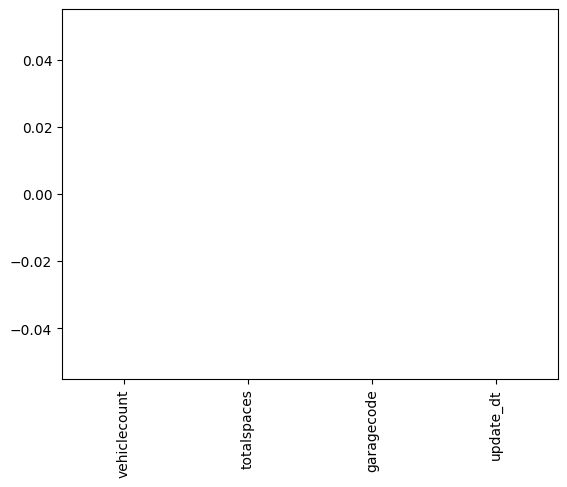

In [10]:
# check for NA values
df.isna().sum().plot.bar()
plt.show()

### Visualize parking data over time at each garage

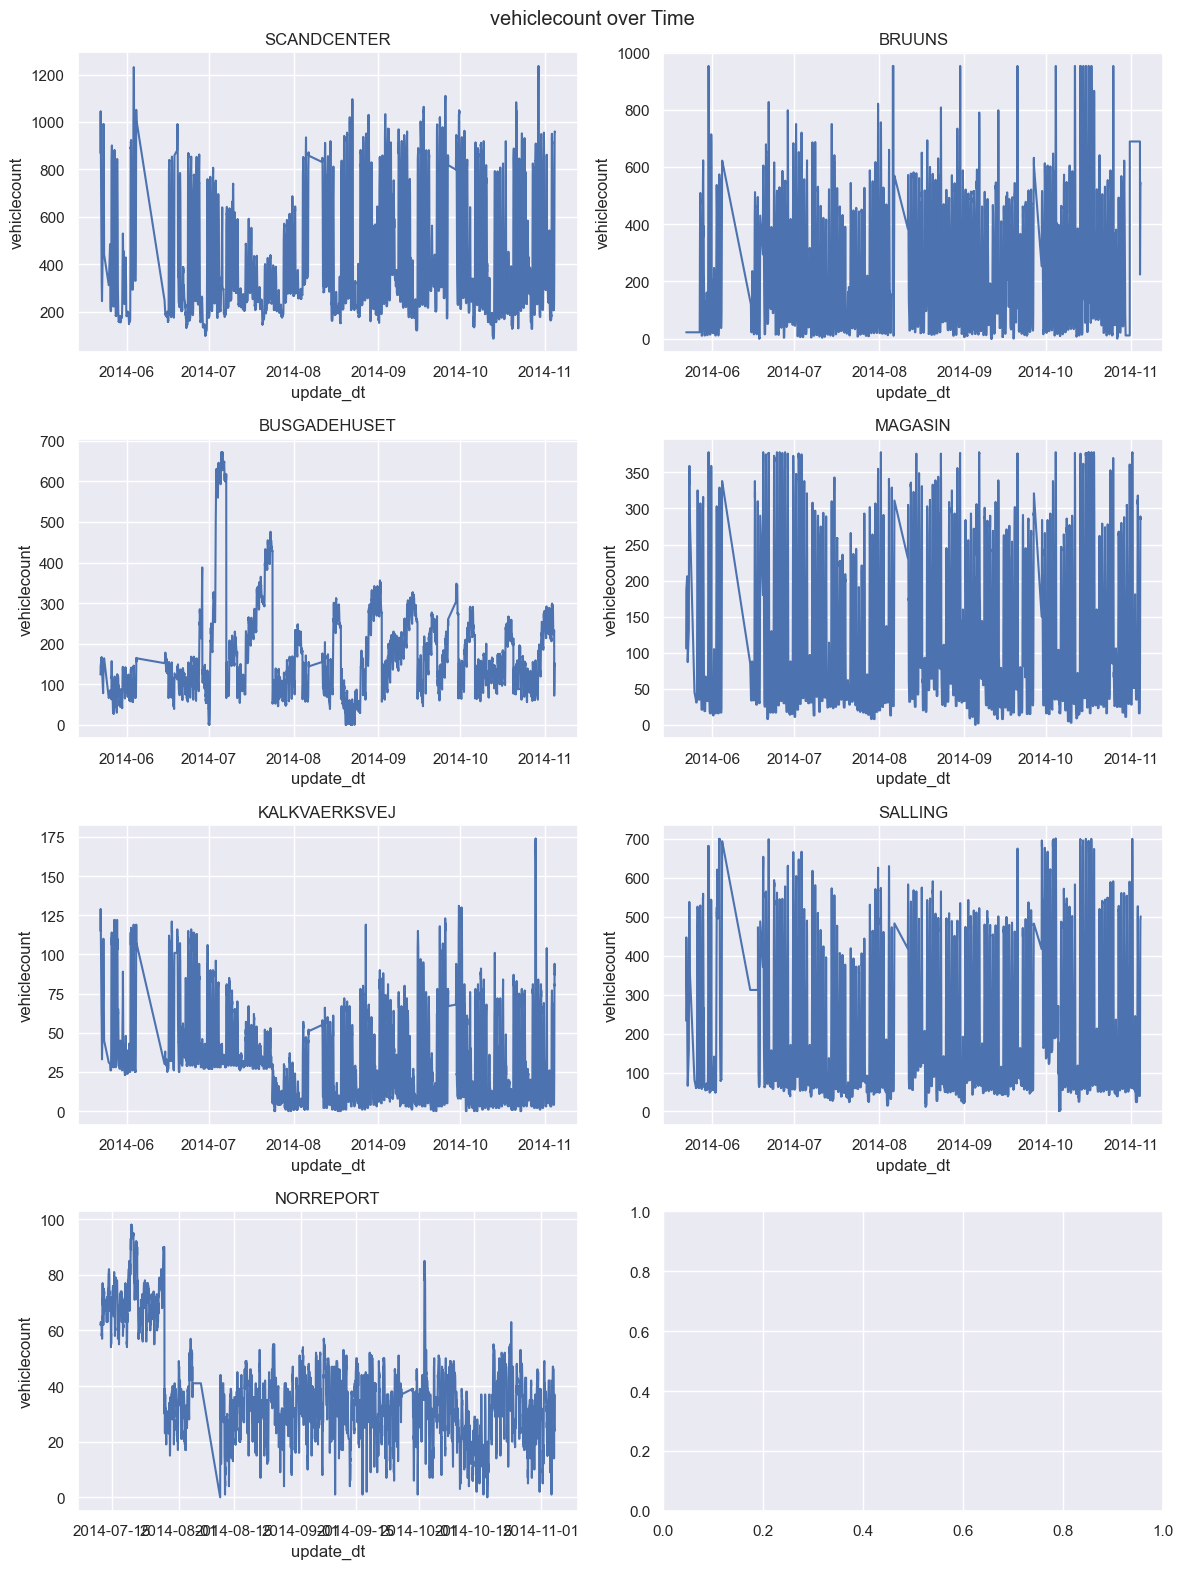

In [30]:
plot_garage_data_over_time(df, 'vehiclecount', individual_plots=False)

The data for garage 'Skolebakken' appears to be inaccurate and will not be useful in training a predictive model. As such, this garage will be dropped from the dataset.  
Additionally, prior to ~ mid July, the garage at Norreport does not appear to be accurately tracking the number of available parking spaces. The data prior to this cutoff, specifically for the Norreport garage, will also be dropped.

In [13]:
# drop skolebakken data
df = df[df['garagecode'] != 'SKOLEBAKKEN']

In [14]:
df[df['garagecode'] == 'NORREPORT'].describe()

,vehiclecount,totalspaces
count,6908.000000,6908.0
mean,29.277794,65.0
std,28.587276,0.0
min,0.000000,65.0
25%,1.000000,65.0
50%,30.000000,65.0
75%,41.000000,65.0
max,1464.000000,65.0


In [15]:
# with the spike in data identified from the .describe() above, we can find the date which the spike occurred
df[df['vehiclecount'] == 1464]

,vehiclecount,totalspaces,garagecode,update_dt
13760,1464,65,NORREPORT,2014-07-11 15:26:49.612


In [16]:
# drop all data points for norreport which occurred prior to 2014-07-12
df = df[(df['garagecode'] != 'NORREPORT') | (df['update_dt'] >= '2014-07-12')]

In [17]:
df.columns

Index(['vehiclecount', 'totalspaces', 'garagecode', 'update_dt'], dtype='object')

## Feature extraction

### Datetime

In [19]:
# extract date and time as individual features
df['date'] = df['update_dt'].dt.date
df['time'] = df['update_dt'].dt.time

In [20]:
# Extracting more from the date
df['date'] = pd.to_datetime(df['date'])
df['weekday'] = df['date'].dt.weekday
df['day'] = df['date'].dt.day
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year

,vehiclecount,totalspaces,garagecode,update_dt,date,time,weekday,day,month,year
2,869,1240,SCANDCENTER,2014-05-22 09:09:04.145,2014-05-22,09:09:04.145000,3,22,5,2014
3,22,953,BRUUNS,2014-05-22 09:09:04.145,2014-05-22,09:09:04.145000,3,22,5,2014
4,124,130,BUSGADEHUSET,2014-05-22 09:09:04.145,2014-05-22,09:09:04.145000,3,22,5,2014
5,106,400,MAGASIN,2014-05-22 09:09:04.145,2014-05-22,09:09:04.145000,3,22,5,2014
6,115,210,KALKVAERKSVEJ,2014-05-22 09:09:04.145,2014-05-22,09:09:04.145000,3,22,5,2014


The extracted datetime information will be further modified through cyclic encoding. Cyclic encoding can be beneficial within time series modeling and predictions to indicate the cyclic nature of certain features such as the time of day, day of the week or month, or month of the year. Rather than existing on a linear scale, these features occur in a cyclic pattern, and can potentially help a model to better account for patterns occurring over time.

In [22]:
# cyclic encoding of datetime information
df['weekday_sin'] = np.sin(2 * np.pi * df['weekday'] / 7)
df['weekday_cos'] = np.cos(2 * np.pi * df['weekday'] / 7)

df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

df['day_sin'] = np.sin(2 * np.pi * df['day'] / 31)
df['day_cos'] = np.cos(2 * np.pi * df['day'] / 31)

df['time_sin'] = np.sin(2 * np.pi * (df['time'].apply(lambda x: x.hour) * 60 + df['time'].apply(lambda x: x.minute)) / (24 * 60))
df['time_cos'] = np.cos(2 * np.pi * (df['time'].apply(lambda x: x.hour) * 60 + df['time'].apply(lambda x: x.minute)) / (24 * 60))

### Parking data

The parking data is currently tracked as the number of occupied spaces (vehiclecount), and as the total number of spaces (totalspaces). However, in order to potentially improve model generalization across multiple garages, an additional feature can be extracted, which is the garage's current capacity as a percentage. I.e a garage that is full would have a capacity of 1, and a garage which is empty would have a capacity of 0.

In [26]:
df['capacity'] = df['vehiclecount'] / df['totalspaces']

In [27]:
df.head()

,vehiclecount,totalspaces,garagecode,update_dt,date,time,weekday,day,month,year,weekday_sin,weekday_cos,month_sin,month_cos,day_sin,day_cos,time_sin,time_cos,capacity
2,869,1240,SCANDCENTER,2014-05-22 09:09:04.145,2014-05-22,09:09:04.145000,3,22,5,2014,0.433884,-0.900969,0.5,-0.866025,-0.968077,-0.250653,0.678801,-0.734323,0.700806
3,22,953,BRUUNS,2014-05-22 09:09:04.145,2014-05-22,09:09:04.145000,3,22,5,2014,0.433884,-0.900969,0.5,-0.866025,-0.968077,-0.250653,0.678801,-0.734323,0.023085
4,124,130,BUSGADEHUSET,2014-05-22 09:09:04.145,2014-05-22,09:09:04.145000,3,22,5,2014,0.433884,-0.900969,0.5,-0.866025,-0.968077,-0.250653,0.678801,-0.734323,0.953846
5,106,400,MAGASIN,2014-05-22 09:09:04.145,2014-05-22,09:09:04.145000,3,22,5,2014,0.433884,-0.900969,0.5,-0.866025,-0.968077,-0.250653,0.678801,-0.734323,0.265000
6,115,210,KALKVAERKSVEJ,2014-05-22 09:09:04.145,2014-05-22,09:09:04.145000,3,22,5,2014,0.433884,-0.900969,0.5,-0.866025,-0.968077,-0.250653,0.678801,-0.734323,0.547619


### Visualizing capacity over time

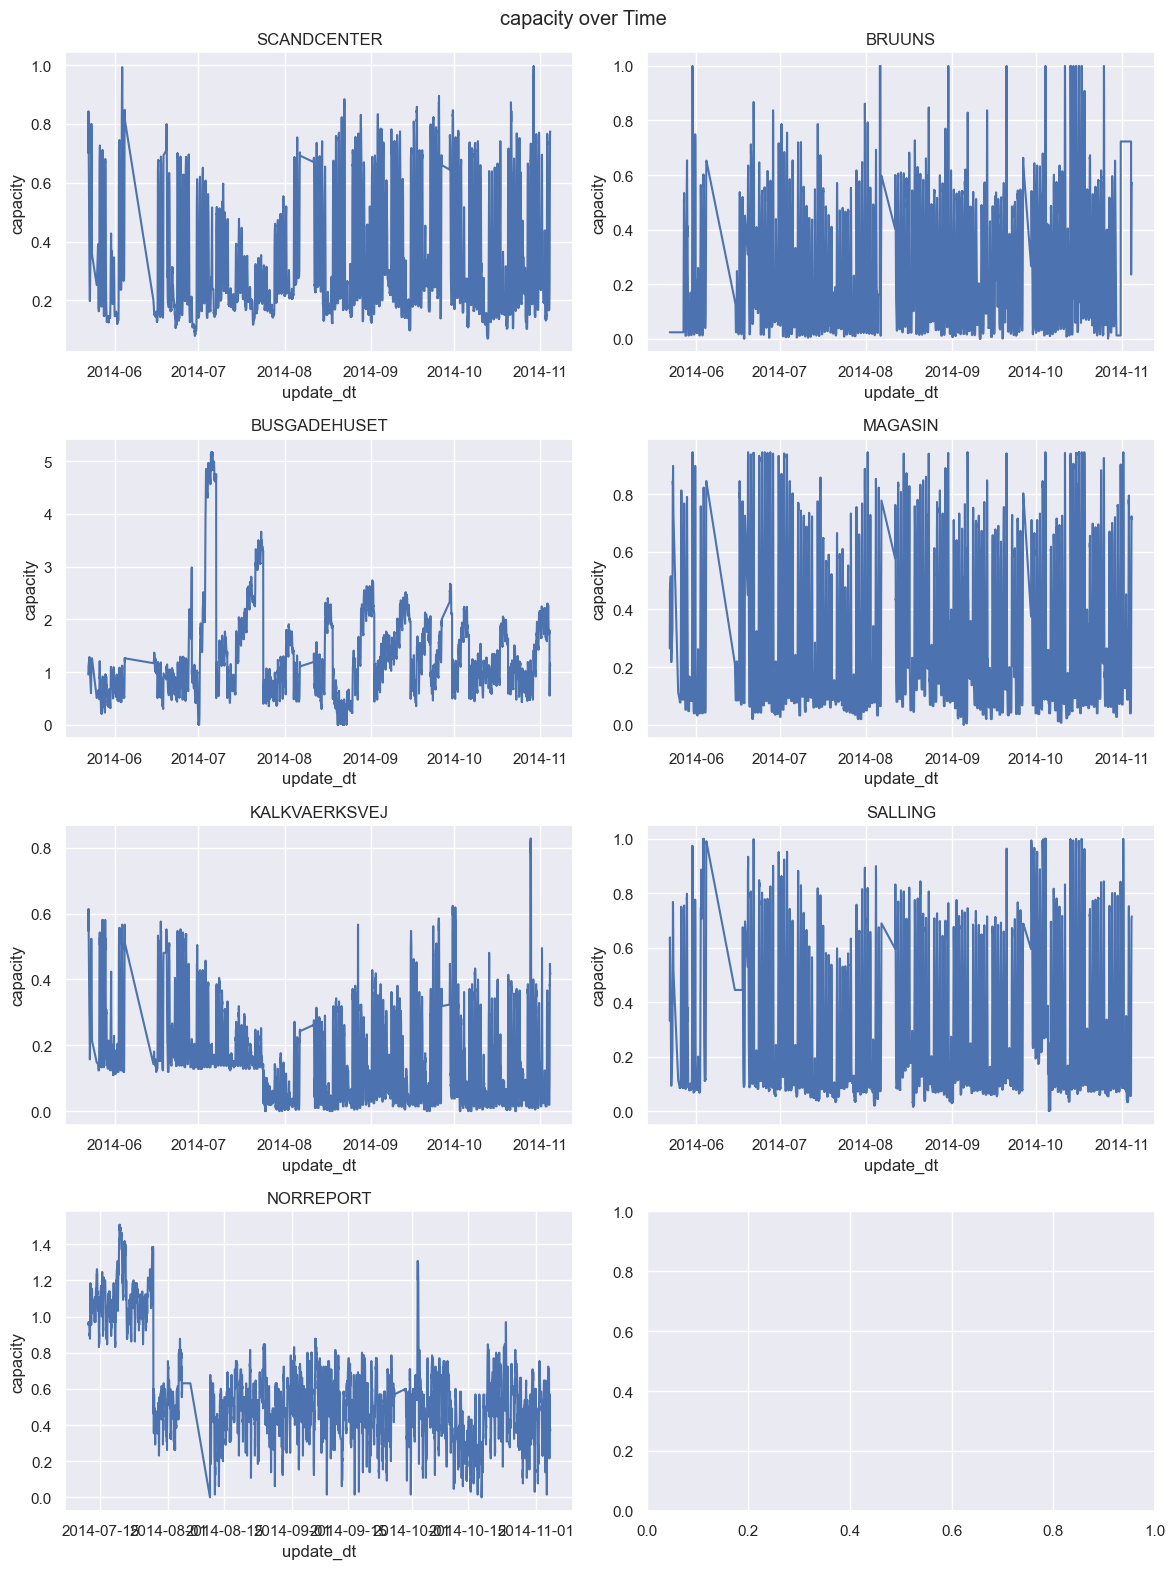

In [31]:
plot_garage_data_over_time(df, 'capacity', individual_plots=False)

Visualizing the capacity of the garages over time, the Busgadehuset garage is regularly significantly over capacity. 

In [ ]:
df.to_csv('parking_data_cleaned.csv', index=False)